<a href="https://colab.research.google.com/github/cabamarcos/Grupo27_practica2/blob/main/Grupo27_practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importación de librerías y datos

Hacemos los imports correspondientes



In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import time

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif 


import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

#preprocessing
from sklearn import preprocessing
from sklearn.compose import make_column_selector as selector
from sympy import *
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#traintest
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

In [3]:
with open('attrition_available_27.pkl', 'rb') as archivo:
    datos = pickle.load(archivo)

print(datos)

           hrs  absences  JobInvolvement  PerformanceRating  \
1     7.315971      13.0             2.0                4.0   
6     6.450877      17.0             3.0                4.0   
13    8.871421      14.0             2.0                3.0   
28         NaN       6.0             2.0                3.0   
30    9.662808      11.0             2.0                3.0   
...        ...       ...             ...                ...   
4405  8.316921       6.0             3.0                3.0   
4406  5.897197       NaN             2.0                3.0   
4407       NaN      18.0             3.0                4.0   
4408  9.187612       NaN             2.0                3.0   
4409  6.511790      17.0             4.0                3.0   

      EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance   Age  \
1                         3.0              2.0              4.0  31.0   
6                         1.0              3.0              1.0   NaN   
13                      

#2. EDA

## Visualización

Convertimos los datos en un dataframe

In [6]:
datosdf = pd.DataFrame(datos)

Sacamos el número de instancias y el número de atributos

In [7]:
print("Número de instancias:", len(datosdf))
print("Número de atributos:", len(datosdf.columns))

Número de instancias: 4410
Número de atributos: 31


Vemos el tipo de datos de las instacias

In [8]:
print("Tipos de datos:")
print(datosdf.dtypes)


Tipos de datos:
hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome           float64
Education                  float64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StandardHours                int64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear      float64
Year

Podemos ver que la mayoría de datos son float, pero también observamos objetos y números enteros

## Datos constantes

Queremos ver si tenemos alguna columna con datos constantes

In [9]:
#creamos un array al que le vamos a meter las columnas que son constantes
columnas_constantes = []
for columna in datosdf.columns:
    if datosdf[columna].nunique() == 1:
        columnas_constantes.append(columna)

if len(columnas_constantes) > 0:
    print("Las siguientes columnas tienen datos constantes:")
    print(columnas_constantes)
else:
    print("No hay columnas con datos constantes.")

Las siguientes columnas tienen datos constantes:
['EmployeeCount', 'Over18', 'StandardHours']


Podemos ver que tenemos 3 coloumnas con satos constantes:
 - EmployeeCount: Número de empleados en la compañía.
 - Over18: Si los empleados son mayores de 18.
 - StandardHours: El número estándar de horas de trabajo en la empresa.

Esto es bastante logico, ya que "EmployeeCount" indica el numero de empleados en la compañía, y este, en el momento de sacar los datos, no varía. Podría variar si se vuelven a sacar los datos x días después.

"Over18", es normal que tenga valores ctes, ya que es un objeto que puede ser o mayor o menor de 18, y sería muy raro que alguien estuviera trabajando en una empresa con menos de 18 años.

Finalmente "StandardHours" como dice su propio nombre, es el número estandar de horas trabajadas en la compañía. Al ser un número estandar, no es personalizado por lo que siempre es el mismo.

Vamos a ver cual es el dato que se repite en cada una de ellas

In [10]:
print("Dato constante en 'EmployeeCount':", datosdf['EmployeeCount'][0])
print("Dato constante en 'Over18':", datosdf['Over18'][0])
print("Dato constante en 'StandardHours':", datosdf['StandardHours'][0])

Dato constante en 'EmployeeCount': 1.0
Dato constante en 'Over18': Y
Dato constante en 'StandardHours': 8


Vamos a comprobar si existen datos nulos en las columnas que estén pasando desapercibido

In [11]:
print("Datos de la columna 'EmployeeCount':")
print(datosdf['EmployeeCount'])

print("\nDatos de la columna 'Over18':")
print(datosdf['Over18'])

print("\nDatos de la columna 'StandardHours':")
print(datosdf['StandardHours'])

Datos de la columna 'EmployeeCount':
1       1.0
6       1.0
13      1.0
28      1.0
30      1.0
       ... 
4405    NaN
4406    NaN
4407    1.0
4408    1.0
4409    NaN
Name: EmployeeCount, Length: 4410, dtype: float64

Datos de la columna 'Over18':
1         Y
6         Y
13        Y
28        Y
30      NaN
       ... 
4405      Y
4406      Y
4407      Y
4408      Y
4409      Y
Name: Over18, Length: 4410, dtype: object

Datos de la columna 'StandardHours':
1       8
6       8
13      8
28      8
30      8
       ..
4405    8
4406    8
4407    8
4408    8
4409    8
Name: StandardHours, Length: 4410, dtype: int64


Podemos ver que esto es cierto, hay datos que faltan.

Vamo a visualizar mejor los datos con unas gráficas.

<Axes: >

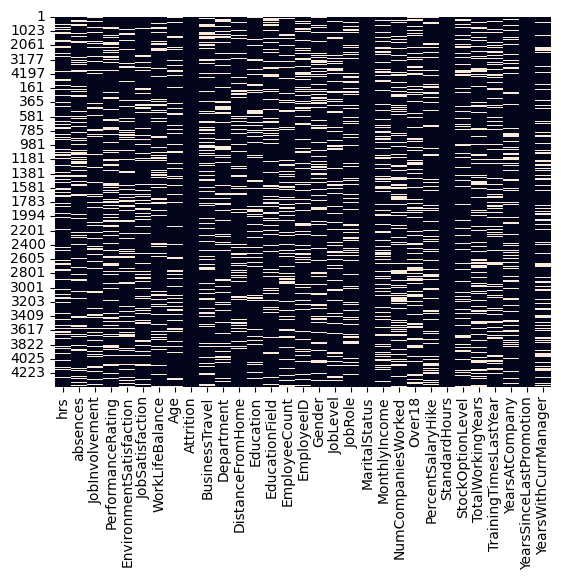

In [12]:
#Mapa de calor con los valores nulos
sns.heatmap(datos.isnull(), cbar=False)

Gracias a estas gráficas y los datos recogidos anteriormente, podemos ver visualmente que hay 4 atributos incluyendo la variable de salida que no cambian sus valores para todas sus instancias, esto significa que está muy desbalanceado.

## Datos nulos

Vamos a comprobar el numero total de datos nulos en cada columna.

In [13]:
nulos_por_columna = datosdf.isnull().sum()
porcentaje_nulos_por_columna = (nulos_por_columna / len(datosdf)) * 100

for columna in datosdf.columns:
    print(f"datos nulos en'{columna}': {nulos_por_columna[columna]}, porcentaje de datos nulos:{porcentaje_nulos_por_columna[columna]:.2f}%")

datos nulos en'hrs': 905, porcentaje de datos nulos:20.52%
datos nulos en'absences': 891, porcentaje de datos nulos:20.20%
datos nulos en'JobInvolvement': 718, porcentaje de datos nulos:16.28%
datos nulos en'PerformanceRating': 919, porcentaje de datos nulos:20.84%
datos nulos en'EnvironmentSatisfaction': 879, porcentaje de datos nulos:19.93%
datos nulos en'JobSatisfaction': 948, porcentaje de datos nulos:21.50%
datos nulos en'WorkLifeBalance': 769, porcentaje de datos nulos:17.44%
datos nulos en'Age': 736, porcentaje de datos nulos:16.69%
datos nulos en'Attrition': 0, porcentaje de datos nulos:0.00%
datos nulos en'BusinessTravel': 849, porcentaje de datos nulos:19.25%
datos nulos en'Department': 782, porcentaje de datos nulos:17.73%
datos nulos en'DistanceFromHome': 747, porcentaje de datos nulos:16.94%
datos nulos en'Education': 715, porcentaje de datos nulos:16.21%
datos nulos en'EducationField': 710, porcentaje de datos nulos:16.10%
datos nulos en'EmployeeCount': 822, porcentaje de

Se puede observar que en ciertas columnas no hay ni un solo missing value, mientras que en otras, el % de missing values puede llegar hasta el 0,21%, más de un quinto de los datos faltan.


## Tipo de problema

Podría tratarse de un problema de regresión por lo que nos piden en el enunciado, pero podemos ver que la variable de salida no es contínua, por lo que no podemos garantizar que se pueda llevar a cabo.

Dadas las circunstancias podemos ver que el problema sería de clasificación binaria, en la que la variable de salida 'Attrition' nos muesta si los empleados abandonan o no la empresa

## ¿Problema desbalanceado?


Se trata de un problema desbalanceado, ya que la variable de salida se encuentra desbalanceada, ya que hay una variable mayoritaria en este atributo, como podemos ver en las gráficas anteriores.

Además, las instancias de los diferentes atributos no son las mismas en cada uno de ellos, hay atributos con clases mayoritarias que contienen más datos y otras menos, pero también hay atributos que tienen demasiados missing values.

Para tratarlo vamos a ver varios métodos que estudiaremos en los siguientes apartados.

# División de datos

Dividiremos los datos en un conjunto train para poder entrenar y ajustar hiper-parámetros, y un conjunto de test para evaluar.

Cabe destacar, que para prblemas de clasificacion desbalanceados, hay que usar particiones estratificadas y médidas adecuadas. También es conveniente que los métodos de construcccion de modelos traten el desbalanceo usando el parametro class_weight = "balanced".

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X = datosdf.drop('Attrition', axis=1)
y = datosdf['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.16666666666666667)

##Preproceso

Vamos a realizar un preprocesado de los datos ya divididos para poder entrenar bien con los modelos que relizaremos en los próximos apartados.

Para rellenar los valores faltantes, vamos a utilizar knn imputer en la columnas necesarias y a la hora de poder convertir variables categóricas en caracterísiticas numéricas binarias para que puedan ser utilizadas por los algoritmos de aprendizaje. Vamos a usar one hot encoder.

In [15]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
set_config(transform_output="pandas")

categorical_cols = ['BusinessTravel','Department','EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']
numerical_cols = list(datosdf.columns)
for item in categorical_cols:
    numerical_cols.remove(item)
numerical_cols.remove('Attrition')
# Procesamiento de valores numéricos.
features_num = numerical_cols
imputer_num = SimpleImputer(strategy='mean')
pipeline_num = Pipeline(
    steps=[
        ("imputer", imputer_num)
    ]
)

# Procesamiento de valores categóricos.
features_cat = categorical_cols
imputer_cat = SimpleImputer(strategy='most_frequent')
pipeline_cat = Pipeline(
    steps=[
        ("imputer", imputer_cat),
        ("encoder", OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
    ]
)

# Pre-procesador "global".
# Dependiendo del tipo de columna se aplica una transformación u otra.
processor = ColumnTransformer(
    transformers=[
        ("num", pipeline_num, features_num),
        ("cat", pipeline_cat, features_cat),
    ]
)


X_train2 = processor.fit_transform(X_train, y_train)

X_test2 = processor.transform(X_test)

In [16]:
print(X_train2.info())
print(X_test2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3675 entries, 2229 to 1650
Data columns (total 50 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   num__hrs                                3675 non-null   float64
 1   num__absences                           3675 non-null   float64
 2   num__JobInvolvement                     3675 non-null   float64
 3   num__PerformanceRating                  3675 non-null   float64
 4   num__EnvironmentSatisfaction            3675 non-null   float64
 5   num__JobSatisfaction                    3675 non-null   float64
 6   num__WorkLifeBalance                    3675 non-null   float64
 7   num__Age                                3675 non-null   float64
 8   num__DistanceFromHome                   3675 non-null   float64
 9   num__Education                          3675 non-null   float64
 10  num__EmployeeCount                      3675 non-null   f

#Construccion de modelos

##Logistic regressor

In [49]:
log_regressor = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))

np.random.seed(27)

start_time = time.time()

log_regressor.fit(X_train2, y_train)

end_time = time.time()

y_pred_train = log_regressor.predict(X_train2)
y_pred_test = log_regressor.predict(X_test2)

total_time = end_time-start_time

print(f'execution time = {total_time}')
print(f'balanced accuracy of default hyperparameters:{balanced_accuracy_score(y_test, y_pred_test)}')
print(f'F1 score on default hyperparameters: {f1_score(y_test, y_pred_test, pos_label = "Yes")}')
print(f'Confusion Matrix on default hyperparameters (train): {confusion_matrix(y_train, y_pred_train)}')
print(f'Confusion Matrix on default hyperparameters (test): {confusion_matrix(y_test, y_pred_test)}')

execution time = 0.06664347648620605
balanced accuracy of default hyperparameters:0.7485676088617266
F1 score on default hyperparameters: 0.4829396325459317
Confusion Matrix on default hyperparameters (train): [[2205  878]
 [ 167  425]]
Confusion Matrix on default hyperparameters (test): [[446 170]
 [ 27  92]]


#Boosting

##Ada boosting

El primer método de boosting en el que vamos a probar el ajuste de hiperparametros es AdaBoosting, diferenciando entre f1 score y balanced accuraccy

In [50]:
adaBoost = make_pipeline(StandardScaler(), AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = 27))

param_grid = {"adaboostclassifier__base_estimator__max_depth":[5,7],#CAMBIAR
              "adaboostclassifier__base_estimator__min_samples_split":[7,9],#CAMBIAR
              "adaboostclassifier__learning_rate":[0.1,1],#CAMBIAR
              "adaboostclassifier__n_estimators":[250, 300]}#CAMBIAR

stratFold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=27)

scoring = make_scorer(balanced_accuracy_score)

clasification = GridSearchCV(adaBoost, 
                             param_grid, 
                             scoring = scoring, 
                             cv = stratFold, 
                             n_jobs = -1, 
                             verbose = 1)

np.random.seed(27)

start_time = time.time()

clasification.fit(X_train2, y_train)

end_time = time.time()


best_model = clasification.best_estimator_
y_pred = best_model.predict(X_train2)

print(f'execution time = {total_time}')
print(f'balanced accuracy of ada: {clasification.best_score_}')
print(f'Confusion Matrix of acaboosting (train): {confusion_matrix(y_train, y_pred)}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


execution time = 0.06664347648620605
balanced accuracy of ada: 0.7298317644429382
Confusion Matrix of acaboosting (train): [[3083    0]
 [   0  592]]


mejor  modelo y parametros #CAMBIAR

In [51]:
best_model = clasification.best_estimator_
best_parameters = clasification.best_params_

print(f"the best parameters are: {best_parameters}")

y_pred = best_model.predict(X_test2)

print(f'balanced accuracy of test {balanced_accuracy_score(y_test, y_pred)}\n')
print(f'Confusion Matrix of acaboosting (test): {confusion_matrix(y_test, y_pred)}\n')

the best parameters are: {'adaboostclassifier__base_estimator__max_depth': 5, 'adaboostclassifier__base_estimator__min_samples_split': 7, 'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 250}
balanced accuracy of test 0.8094442322383499

Confusion Matrix of acaboosting (test): [[609   7]
 [ 44  75]]



In [52]:
adaBoost = make_pipeline(StandardScaler(), AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = 27))

param_grid = {"adaboostclassifier__base_estimator__max_depth":[2, 3, 4],  #CAMBIAR
              "adaboostclassifier__base_estimator__min_samples_split":[2, 3, 4],#CAMBIAR
              "adaboostclassifier__learning_rate":[0.0001,0.001, 0.01],#CAMBIAR
              "adaboostclassifier__n_estimators":[5, 10, 15]}#CAMBIAR

stratFold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=27)

scoring = make_scorer(f1_score, average = "weighted")

clasification = GridSearchCV(adaBoost, 
                             param_grid, 
                             scoring = scoring, 
                             cv = stratFold, 
                             n_jobs = -1, 
                             verbose = 1)

np.random.seed(27)

start_time = time.time()

clasification.fit(X_train2, y_train)

end_time = time.time()


best_model = clasification.best_estimator_
y_pred = best_model.predict(X_train2)

total_time = end_time - start_time
print(f'execution time = {total_time}\n')
print(f'balanced accuracy of ada: {clasification.best_score_}\n')
print(f'Confusion Matrix of acaboosting (train): {confusion_matrix(y_train, y_pred)}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
execution time = 33.60704231262207

balanced accuracy of ada: 0.8107716730638633

Confusion Matrix of acaboosting (train): [[3060   23]
 [ 498   94]]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


IGUAL #CAMBIAR

In [53]:
best_model = clasification.best_estimator_
best_parameters = clasification.best_params_

print(f"the best parameters are: {best_parameters}")

y_pred = best_model.predict(X_test2)
f1 = f1_score(y_test, y_pred, pos_label ='Yes', average = "weighted")
print(f'F1 score of test {f1}\n')
print(f'Confusion Matrix of acaboosting for f1 score (test): {confusion_matrix(y_test, y_pred)}')

the best parameters are: {'adaboostclassifier__base_estimator__max_depth': 4, 'adaboostclassifier__base_estimator__min_samples_split': 2, 'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 5}
F1 score of test 0.7864597578135837

Confusion Matrix of acaboosting for f1 score (test): [[606  10]
 [109  10]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'Yes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


##GradientBoosting

In [54]:
gradientBoost =  make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = 27))

param_grid = {"gradientboostingclassifier__learning_rate":[0.1, 1],  #CAMBIAR
              "gradientboostingclassifier__max_depth":[5, 7],#CAMBIAR
              "gradientboostingclassifier__min_samples_split":[7, 9],#CAMBIAR
              "gradientboostingclassifier__n_estimators":[250, 300]}#CAMBIAR

stratFold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=27)

scoring = make_scorer(balanced_accuracy_score)

clasification = GridSearchCV(gradientBoost, 
                             param_grid, 
                             scoring = scoring, 
                             cv = stratFold, 
                             n_jobs = -1, 
                             verbose = 1)

np.random.seed(27)

start_time = time.time()

clasification.fit(X_train2, y_train)

end_time = time.time()


best_model = clasification.best_estimator_
y_pred = best_model.predict(X_train2)

total_time = end_time - start_time
print(f'execution time = {total_time}\n')
print(f'balanced accuracy of ada: {clasification.best_score_}\n')
print(f'Confusion Matrix of gradientBoost (train): {confusion_matrix(y_train, y_pred)}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
execution time = 146.76625871658325

balanced accuracy of ada: 0.7657379276009314

Confusion Matrix of gradientBoost (train): [[3083    0]
 [   0  592]]


In [55]:
best_model = clasification.best_estimator_
best_parameters = clasification.best_params_

print(f"the best parameters are: {best_parameters}")

y_pred = best_model.predict(X_test2)

print(f'balanced accuracy of test {balanced_accuracy_score(y_test, y_pred)}\n')
print(f'Confusion Matrix of gradientBoosting (test): {confusion_matrix(y_test, y_pred)}\n')

the best parameters are: {'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__min_samples_split': 9, 'gradientboostingclassifier__n_estimators': 300}
balanced accuracy of test 0.8624427043544691

Confusion Matrix of gradientBoosting (test): [[607   9]
 [ 31  88]]



In [56]:
gradientBoost =  make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = 27))

param_grid = {"gradientboostingclassifier__learning_rate":[0.0001,0.001, 0.01],  #CAMBIAR
              "gradientboostingclassifier__max_depth":[2, 3, 4],#CAMBIAR
              "gradientboostingclassifier__min_samples_split":[2, 3, 4],#CAMBIAR
              "gradientboostingclassifier__n_estimators":[5, 10, 15]}#CAMBIAR

stratFold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=27)

scoring = make_scorer(f1_score, average = "weighted")

clasification = GridSearchCV(gradientBoost, 
                             param_grid, 
                             scoring = scoring, 
                             cv = stratFold, 
                             n_jobs = -1, 
                             verbose = 1)

np.random.seed(27)

start_time = time.time()

clasification.fit(X_train2, y_train)

end_time = time.time()


best_model = clasification.best_estimator_
y_pred = best_model.predict(X_train2)

total_time = end_time - start_time
print(f'execution time = {total_time}\n')
print(f'f1 score of gradientBoost: {clasification.best_score_}\n')
print(f'Confusion Matrix of gradientBoost for f1 score (train): {confusion_matrix(y_train, y_pred)}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
execution time = 22.59752345085144

f1 score of gradientBoost: 0.7654230585085801

Confusion Matrix of gradientBoost for f1 score (train): [[3083    0]
 [ 592    0]]


In [57]:
best_model = clasification.best_estimator_
best_parameters = clasification.best_params_

print(f"the best parameters are: {best_parameters}")

y_pred = best_model.predict(X_test2)

f1 = f1_score(y_test, y_pred, pos_label ='Yes', average = "weighted")
print(f'F1 score of test {f1}\n')
print(f'Confusion Matrix of acaboosting for f1 score (test): {confusion_matrix(y_test, y_pred)}')

the best parameters are: {'gradientboostingclassifier__learning_rate': 0.0001, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 5}
F1 score of test 0.7642733777448802

Confusion Matrix of acaboosting for f1 score (test): [[616   0]
 [119   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'Yes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


##XGBoost

In [58]:
XGBoost =  make_pipeline(StandardScaler(), xgb.XGBClassifier(random_state = 27))

param_grid = {"xgbclassifier__learning_rate":[0.1, 1],  #CAMBIAR
              "xgbclassifier__max_depth":[6, 7],#CAMBIAR
              "xgbclassifier__min_child_weight":[1, 2],#CAMBIAR
              "xgbclassifier__n_estimators":[160, 180],#CAMBIAR
              "xgbclassifier__scale_pos_weight":[5, 10, 15]}#CAMBIAR

stratFold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=27)

scoring = make_scorer(balanced_accuracy_score)

clasification = GridSearchCV(XGBoost, 
                             param_grid, 
                             scoring = scoring, 
                             cv = stratFold, 
                             n_jobs = -1, 
                             verbose = 1)

np.random.seed(27)
y_train2 = y_train.map({'No':0, 'Yes':1})

start_time = time.time()

clasification.fit(X_train2, y_train2)

end_time = time.time()


best_model = clasification.best_estimator_
y_pred = best_model.predict(X_train2)

total_time = end_time - start_time
print(f'execution time = {total_time}\n')
print(f' balanced accuracy of XGBoost: {clasification.best_score_}\n')
print(f'Confusion Matrix of XGBoost (train): {confusion_matrix(y_train2, y_pred)}')
y_train2 = y_train

Fitting 3 folds for each of 48 candidates, totalling 144 fits
execution time = 185.08043813705444

 balanced accuracy of XGBoost: 0.8058105010788981

Confusion Matrix of XGBoost (train): [[3063   20]
 [   0  592]]


In [59]:
best_model = clasification.best_estimator_
best_parameters = clasification.best_params_

print(f"the best parameters are: {best_parameters}")

y_test2 = y_test.map({'No':0, 'Yes':1})

y_pred = best_model.predict(X_test2)

balancedAcc = balanced_accuracy_score(y_test2, y_pred)
print(f'balanced accuracy of test {balancedAcc}\n')
print(f'Confusion Matrix of XGBoost (test): {confusion_matrix(y_test2, y_pred)}\n')
y_test2 = y_test

the best parameters are: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 160, 'xgbclassifier__scale_pos_weight': 15}
balanced accuracy of test 0.8933823529411764

Confusion Matrix of XGBoost (test): [[583  33]
 [ 19 100]]



In [60]:
XGBoost =  make_pipeline(StandardScaler(), xgb.XGBClassifier(random_state = 27))

param_grid = {"xgbclassifier__learning_rate":[0.1, 1],  #CAMBIAR
              "xgbclassifier__max_depth":[6, 7],#CAMBIAR
              "xgbclassifier__min_child_weight":[1, 2],#CAMBIAR
              "xgbclassifier__n_estimators":[160, 180],#CAMBIAR
              "xgbclassifier__scale_pos_weight":[5, 10, 15]}#CAMBIAR

stratFold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=27)

scoring = make_scorer(f1_score)

clasification = GridSearchCV(XGBoost, 
                             param_grid, 
                             scoring = scoring, 
                             cv = stratFold, 
                             n_jobs = -1, 
                             verbose = 1)

np.random.seed(27)
y_train2 = y_train.map({'No':0, 'Yes':1})

start_time = time.time()

clasification.fit(X_train2, y_train2)

end_time = time.time()


best_model = clasification.best_estimator_
y_pred = best_model.predict(X_train2)

total_time = end_time - start_time
print(f'execution time = {total_time}\n')
print(f' f1 score of XGBoost: {clasification.best_score_}\n')
print(f'Confusion Matrix of XGBoost for f1 score (train): {confusion_matrix(y_train2, y_pred)}')
y_train2 = y_train

Fitting 3 folds for each of 48 candidates, totalling 144 fits
execution time = 184.2087116241455

 f1 score of XGBoost: 0.6847199020817016

Confusion Matrix of XGBoost for f1 score (train): [[3083    0]
 [   0  592]]


In [61]:
best_model = clasification.best_estimator_
best_parameters = clasification.best_params_

print(f"the best parameters are: {best_parameters}")
y_test2 = y_test.map({'No':0, 'Yes':1})
y_pred = best_model.predict(X_test2)

f1 = f1_score(y_test2, y_pred)
print(f'F1 score of test {f1}\n')
print(f'Confusion Matrix of XGBoost for f1 score (test): {confusion_matrix(y_test2, y_pred)}')
y_test2 = y_test

the best parameters are: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__n_estimators': 180, 'xgbclassifier__scale_pos_weight': 15}
F1 score of test 0.8

Confusion Matrix of XGBoost for f1 score (test): [[591  25]
 [ 23  96]]


#Seleccion de atributos

selectkbest mutual balanced

In [18]:
XGBoost =  make_pipeline(StandardScaler(), SelectKBest(mutual_info_classif), xgb.XGBClassifier(random_state = 27))

param_grid = {"xgbclassifier__learning_rate":[0.1, 1],  #CAMBIAR
              "xgbclassifier__max_depth":[6, 7],#CAMBIAR
              "xgbclassifier__min_child_weight":[1, 2],#CAMBIAR
              "xgbclassifier__n_estimators":[160, 180],#CAMBIAR
              "selectkbest__k":[25, 30],#CAMBIAR
              "xgbclassifier__scale_pos_weight":[5, 10, 15]}#CAMBIAR

stratFold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=27)

scoring = make_scorer(balanced_accuracy_score)

clasification = GridSearchCV(XGBoost, 
                             param_grid, 
                             scoring = scoring, 
                             cv = stratFold, 
                             n_jobs = -1, 
                             verbose = 1)

np.random.seed(27)
y_train2 = y_train.map({'No':0, 'Yes':1})

start_time = time.time()

clasification.fit(X_train2, y_train2)

end_time = time.time()


best_model = clasification.best_estimator_
y_pred = best_model.predict(X_train2)

total_time = end_time - start_time
print(f'execution time = {total_time}\n')
print(f' balanced accuracy of XGBoost: {clasification.best_score_}\n')
print(f'Confusion Matrix of XGBoost (train): {confusion_matrix(y_train2, y_pred)}')
y_train2 = y_train

Fitting 3 folds for each of 96 candidates, totalling 288 fits
execution time = 392.26824975013733

 balanced accuracy of XGBoost: 0.8090507759870654

Confusion Matrix of XGBoost (train): [[3043   40]
 [   0  592]]


In [19]:
best_model = clasification.best_estimator_
best_parameters = clasification.best_params_

print(f"the best parameters are: {best_parameters}")

y_test2 = y_test.map({'No':0, 'Yes':1})

y_pred = best_model.predict(X_test2)

balancedAcc = balanced_accuracy_score(y_test2, y_pred)
print(f'balanced accuracy of test {balancedAcc}\n')
print(f'Confusion Matrix of XGBoost (test): {confusion_matrix(y_test2, y_pred)}\n')
y_test2 = y_test

the best parameters are: {'selectkbest__k': 30, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 160, 'xgbclassifier__scale_pos_weight': 15}
balanced accuracy of test 0.8627769289533995

Confusion Matrix of XGBoost (test): [[566  50]
 [ 23  96]]



selectkbest mutual f1

In [20]:
XGBoost =  make_pipeline(StandardScaler(), SelectKBest(mutual_info_classif), xgb.XGBClassifier(random_state = 27))

param_grid = {"xgbclassifier__learning_rate":[0.1, 1],  #CAMBIAR
              "xgbclassifier__max_depth":[6, 7],#CAMBIAR
              "xgbclassifier__min_child_weight":[1, 2],#CAMBIAR
              "xgbclassifier__n_estimators":[160, 180],#CAMBIAR
              "selectkbest__k":[25, 30],#CAMBIAR
              "xgbclassifier__scale_pos_weight":[5, 10, 15]}#CAMBIAR

stratFold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=27)

scoring = make_scorer(f1_score, average = "weighted")

clasification = GridSearchCV(XGBoost, 
                             param_grid, 
                             scoring = scoring, 
                             cv = stratFold, 
                             n_jobs = -1, 
                             verbose = 1)

np.random.seed(27)
y_train2 = y_train.map({'No':0, 'Yes':1})

start_time = time.time()

clasification.fit(X_train2, y_train2)

end_time = time.time()


best_model = clasification.best_estimator_
y_pred = best_model.predict(X_train2)

total_time = end_time - start_time
print(f'execution time = {total_time}\n')
print(f' balanced accuracy of XGBoost: {clasification.best_score_}\n')
print(f'Confusion Matrix of XGBoost (train): {confusion_matrix(y_train2, y_pred)}')
y_train2 = y_train

Fitting 3 folds for each of 96 candidates, totalling 288 fits
execution time = 389.142213344574

 balanced accuracy of XGBoost: 0.901274704147982

Confusion Matrix of XGBoost (train): [[3082    1]
 [   0  592]]


In [21]:
best_model = clasification.best_estimator_
best_parameters = clasification.best_params_

print(f"the best parameters are: {best_parameters}")

y_test2 = y_test.map({'No':0, 'Yes':1})

y_pred = best_model.predict(X_test2)

f1 = f1_score(y_test2, y_pred, average = "weighted")
print(f'F1 score of test {f1}\n')
print(f'Confusion Matrix of XGBoost (test): {confusion_matrix(y_test2, y_pred)}\n')
y_test2 = y_test

the best parameters are: {'selectkbest__k': 30, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 160, 'xgbclassifier__scale_pos_weight': 10}
F1 score of test 0.9336669041276572

Confusion Matrix of XGBoost (test): [[590  26]
 [ 23  96]]

